# Livable Streets: Bike Infrastructure & Displacement
## Project Deliverable 1

#### Siddharth Bookinkere, Alexander Heger, Kwan Wing Tuet, Raviv Zait

## Introduction

Our analytical task is to identify if there is a causal relationship between bike infrastructure development and displacement in Boston, Massachusetts. Working with our client, Livable Streets, we considered that displacement is caused by significant changes in a community's race, income, property value, and/or ratio of homeowners to renters. We turned to the [United States Census' American Community Survey's Five-Year Estimates](https://data.census.gov/table?g=1400000US25025070800,25025070801,25025070900,25025070901,25025080100,25025080300,25025080500,25025080601,25025081300,25025081301,25025081302,25025081400,25025081500,25025081700,25025081800,25025081900,25025082000,25025082100,25025090100,25025090200,25025090300,25025090400,25025090600,25025090700,25025090900,25025090901,25025091000,25025091001,25025091100,25025091200,25025091300,25025091400,25025091500,25025091600,25025091700,25025091800,25025091900,25025092000,25025092100,25025092101,25025092200,25025092300,25025092400,25025100100,25025100200,25025100300,25025100400,25025100500,25025100601,25025100602,25025100603,25025100700,25025100800,25025110105,25025120104,25025120201&d=ACS%205-Year%20Estimates%20Detailed%20Tables) to obtain data on these factors leading to displacement. The data we use on bike infrastructure comes from the City of Boston's [Boston Bikes Data webpage](https://experience.arcgis.com/experience/925eb7fd89c24c5f9c07bcc20ee9ea74/).

In this notebook, we present our data, conduct preliminary analysis on each variable, answer three key questions, and discuss our project's scope and limitations. The key questions we explore are: (1) is there _correlation_ between bike lane development and the factors leading to displacement, (2) do different types of bike lanes yield different effects, and (3) what are the demographic and socioeconomic characteristics of neighborhoods where bike lanes are built?

Our future work will be a difference-in-difference analysis on each of the demographic and socioeconomic features of our data with changes in bike lane infrastructure as the independent variable.

### Clone repository

In [ ]:
# !git clone https://github.com/BU-Spark/ds-livable-streets-infra.git

## Collect and Pre-process Census and Bike Data

### Read data

The data we collected from the American Community Survey's detailed tables comes from the following surveys:

> Race: __DP05__ - ACS Demographic and Housing Estimates
> Income: __S1901__ - Income in the Past 12 Months (in 2021 Inflation-Adjusted Dollars)
> Property Value: __DP04__ - Selected Housing Characteristics
> Home Ownership: __B25026__ - Total Population in Occupied Housing Units by Tenure by Year Householder Moved into Unit

External to this notebook, we cleaned and organized these data into consolidated tables that we merge below.

In [27]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import csv
import sklearn
import warnings

warnings.filterwarnings("ignore")

# Set the current working directory to the root of the repository
os.chdir("C:/Users/Alex H/OneDrive/Documents/BU Fall 2023/DS701/ds-livable-streets-infra/")
# os.chdir(r"C:\Users\Raviv\AppData\Roaming\Microsoft\Windows\Start Menu\Programs\Python 3.10\ds-livable-streets-infra")

# Customize data folder
data_folder = "fa23-team/data/"

# Read demographic and property value data
combined_demo_prop = pd.read_csv(data_folder + "combined_demo_prop.csv", index_col=False)
print("Demographic and property value data shape: ", combined_demo_prop.shape)

# Read income and house ownership data
combined_income_owner = pd.read_csv(data_folder+"income_houseownership.csv", index_col=False)
print("Income and house ownership data shape: ",combined_income_owner.shape)

# Read bike infrastructure data
bike_file_path = data_folder + '/Existing_Bike_Network_2023.geojson'
bike_lanes = gpd.read_file(bike_file_path)
print("Bike infrastructure shape: ", bike_lanes.shape)

bike_data = pd.read_csv(data_folder + "bike_combined_data_8-11.csv", index_col=False)
print("Bike aggregated data shape: ", bike_data.shape)

tracts_2010_file_path = data_folder + 'Census_2010_Tracts.geojson' #https://data.boston.gov/dataset/census-2010-tracts
tracts_2010 = gpd.read_file(tracts_2010_file_path)
print("Tracts 2010 shape: ", tracts_2010.shape)

Demographic and property value data shape:  (564, 16)
Income and house ownership data shape:  (606, 17)
Bike infrastructure shape:  (3243, 11)
Bike aggregated data shape:  (720, 13)
Tracts 2010 shape:  (181, 19)


### Clean Income and House Ownership Data

Throughout out data gathering phase, we considered including different features and Census Tracts. The next few cells refine our data pulls to include only the data we'll use for our final analysis.

In [3]:
# Drop diff columns
combined_income_owner.drop(["median_income_difference", "mean_income_difference"], axis=1,
                           inplace=True)

# Rename columns
combined_income_owner.columns = ["year", "median_income", "mean_income", "tract", "housed_population", "owner_occupied", "owner_occupied_pre-2000", "renter_occupied", "renter_occupied_pre-2000", "percent_owners", "percent_renters", "percent_owners_pre-2000", "percent_renters_pre-2000", "owners_renters_ratio", "owners_renters_pre-2000_ratio"]

# Reorder columns
leading_cols = ['tract', 'year']
combined_income_owner = combined_income_owner[leading_cols + [col for col in combined_income_owner.columns if col not in leading_cols]]

print(combined_income_owner.shape)

(606, 15)


In [4]:
# Drop redundant tracts
drop_tracts = [708.00, 708.01, 709.00, 709.01, 813.00, 1103.03]

combined_income_owner = combined_income_owner[~combined_income_owner['tract'].isin(drop_tracts)]
combined_income_owner.tract.nunique()

47

In [5]:
# Revert to 2010 tract names
combined_income_owner = combined_income_owner.replace(813.02, 813.00)
combined_income_owner = combined_income_owner.replace(1101.05, 1101.03)

### Clean Bike Data

Before we can merge the data from the Census with the Boston Bikes data, we want to ensure `tract`, our primary identifier for each geolocation, is uniformly formatted across all tables.

In [6]:
# Remove index column
bike_data = bike_data.drop("Unnamed: 0", axis=1)

# Make tract a string
bike_data.tract = bike_data.tract.astype(str)
bike_data.tract = bike_data.tract.str.replace(r'\.0$', '', regex=True)

# Make year an int
bike_lanes['year'] = pd.to_numeric(bike_lanes['InstallDat'], errors = 'coerce').astype('Int64')

### Merge Census Data

Here, we merge the two earlier tables from the U.S. Census ahead of our merge with the bike infrastructure data.

In [7]:
# Make tract a string
combined_income_owner.tract = combined_income_owner.tract.astype(str)
combined_demo_prop.tract = combined_demo_prop.tract.astype(str)

In [8]:
# Combine Census Data
census = pd.merge(combined_demo_prop, combined_income_owner, on=["tract", "year"])
census = census.sort_values(['tract', 'year'])
census.shape

(564, 29)

In [9]:
# Remove trailing ".0" in string tracts
census.tract = census.tract.str.replace(r'\.0$', '', regex=True)

In [10]:
# Generate lists of tracts in neighborhoods for later labeling
dorchester = ["901", "902", "903", "904", "906", "907", "909.01",
              "910.01", "911", "912", "913", "914", "915", "916",
              "917", "918", "919", "920", "921.01", "922", "923",
              "924", "1001", "1002", "1003", "1004", "1005", "1006.01",
              "1006.03", "1007", "1008"]
roxbury = ["801", "803", "804.01", "805", "806.01", "813", "814",
           "815", "817", "818", "819", "820", "821"]
jp = ["1201.04", "1202.01", "1101.03"]

It is important to note that, since we are using areas in Jamaica Plain as a point of comparison to changes in Dorchester and Roxbury, we only use 3 out of 14 of its Census Tracts.

### Merge Census and Bike Infrastructure Data

Finally, we can merge our Census and bike infrastructure data into one table!

In [11]:
# ID tracts in bike_data that are not in census
rogue_tracts = [i for i in bike_data.tract.unique() if i not in census.tract.unique()]
rogue_tracts

['708', '709']

In [12]:
# Remove rogue tracts
bike_data = bike_data[~bike_data['tract'].isin(rogue_tracts)]
bike_data.shape

(688, 12)

In [13]:
# Merge census and bike data
census_bike = pd.merge(census, bike_data, on=['tract', 'year'], how="outer")

census_bike.shape

(736, 39)

In [14]:
census_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 736 entries, 0 to 735
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tract                          736 non-null    object 
 1   year                           736 non-null    int64  
 2   total_population               564 non-null    float64
 3   male                           564 non-null    float64
 4   female                         564 non-null    float64
 5   median_age                     564 non-null    float64
 6   race_white                     564 non-null    float64
 7   race_black                     564 non-null    float64
 8   race_ai_alaskan                564 non-null    float64
 9   race_asian                     564 non-null    float64
 10  race_hawaiian                  564 non-null    float64
 11  race_other                     564 non-null    float64
 12  race_hispanic                  564 non-null    flo

### Preprocess Merged Census and Bike Infrastructure Data

Now that the data is all merged, we add neighborhood names to make rows more interpretable, and we reorganize the columns for easier visualization.

In [15]:
# Set neighborhood labels
def set_neighborhood(tract):
    if tract in dorchester:
        return "Dorchester"
    elif tract in roxbury:
        return "Roxbury"
    elif tract in jp:
        return "Jamaica Plain"
    else:
        return ''

census_bike['neighborhood'] = census_bike['tract'].apply(set_neighborhood)

In [16]:
# Reorder columns
leading_cols = ['tract', 'year', 'neighborhood']
census_bike = census_bike[leading_cols + [col for col in census_bike.columns if col not in leading_cols]]

In [ ]:
# Save combined file
# census_bike.to_csv(data_folder + "census_bike_merged.csv", index=False)

In [17]:
census_bike.head()

,tract,year,neighborhood,total_population,male,female,median_age,race_white,race_black,race_ai_alaskan,...,BFBL,BL,BLSL,SBL,SBLBL,SLM,SLMTC,SUP,total_built_all_lanes,cumulative_length
0,1001,2010,Dorchester,5617.0,0.481,0.519,23.9,0.063,0.638,0.012,...,0.0,2493.815844,0.0,0.0,0.0,563.192706,0.0,0.0,3057.008550,3167.046929
1,1001,2011,Dorchester,5657.0,0.480,0.520,24.5,0.109,0.619,0.014,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,3167.046929
2,1001,2012,Dorchester,6189.0,0.451,0.549,25.2,0.074,0.701,0.004,...,0.0,851.779668,0.0,0.0,0.0,684.141817,0.0,0.0,1535.921485,4702.968414
3,1001,2013,Dorchester,6295.0,0.433,0.567,27.3,0.112,0.727,0.001,...,0.0,36.450628,0.0,0.0,0.0,0.000000,0.0,0.0,36.450628,4739.419042
4,1001,2014,Dorchester,6371.0,0.455,0.545,31.2,0.131,0.750,0.001,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,4739.419042


## Preliminary Analysis

### Race and Neighborhood

We begin our preliminary analysis by looking at race in the contexts of the neighborhoods, Dorchester and Roxbury.

In [20]:
# ID columns pertaining to race, neighborhood
columns = census_bike.columns[[0,1,2] + list(range(7, 14))] # Add all race columns
df_race = census_bike[list(columns)]

# Reshape data to look at race, neighborhood
df_race_melt = pd.melt(df_race, id_vars=['year', 'tract', 'neighborhood'], var_name='race', value_name='percentage')
df_race_melt

,year,tract,neighborhood,race,percentage
0,2010,1001,Dorchester,race_white,0.063
1,2011,1001,Dorchester,race_white,0.109
2,2012,1001,Dorchester,race_white,0.074
3,2013,1001,Dorchester,race_white,0.112
4,2014,1001,Dorchester,race_white,0.131
...,...,...,...,...,...
5147,2022,923,Dorchester,race_hispanic,NaN
5148,2007,924,Dorchester,race_hispanic,NaN
5149,2008,924,Dorchester,race_hispanic,NaN
5150,2009,924,Dorchester,race_hispanic,NaN


In [21]:
# Set Hispanic as ethnicity
def transform_race(value):
    if value == 'race_hispanic':
        return 'ethnicity_hispanic'
    elif value == 'race_white':
        return 'white'
    else:
        return 'non_white'

# Apply the transformation to the 'race' column
df_race_melt['race_2'] = df_race_melt['race'].apply(transform_race)
df_race_melt

,year,tract,neighborhood,race,percentage,race_2
0,2010,1001,Dorchester,race_white,0.063,white
1,2011,1001,Dorchester,race_white,0.109,white
2,2012,1001,Dorchester,race_white,0.074,white
3,2013,1001,Dorchester,race_white,0.112,white
4,2014,1001,Dorchester,race_white,0.131,white
...,...,...,...,...,...,...
5147,2022,923,Dorchester,race_hispanic,NaN,ethnicity_hispanic
5148,2007,924,Dorchester,race_hispanic,NaN,ethnicity_hispanic
5149,2008,924,Dorchester,race_hispanic,NaN,ethnicity_hispanic
5150,2009,924,Dorchester,race_hispanic,NaN,ethnicity_hispanic


In [22]:
# Compare white and non-white populations
df_race_melt[((df_race_melt['race_2']== 'non_white') |(df_race_melt['race_2']== 'white'))
             & (df_race_melt['year']== 2010)].race_2.unique()

array(['white', 'non_white'], dtype=object)

<Figure size 1800x400 with 0 Axes>

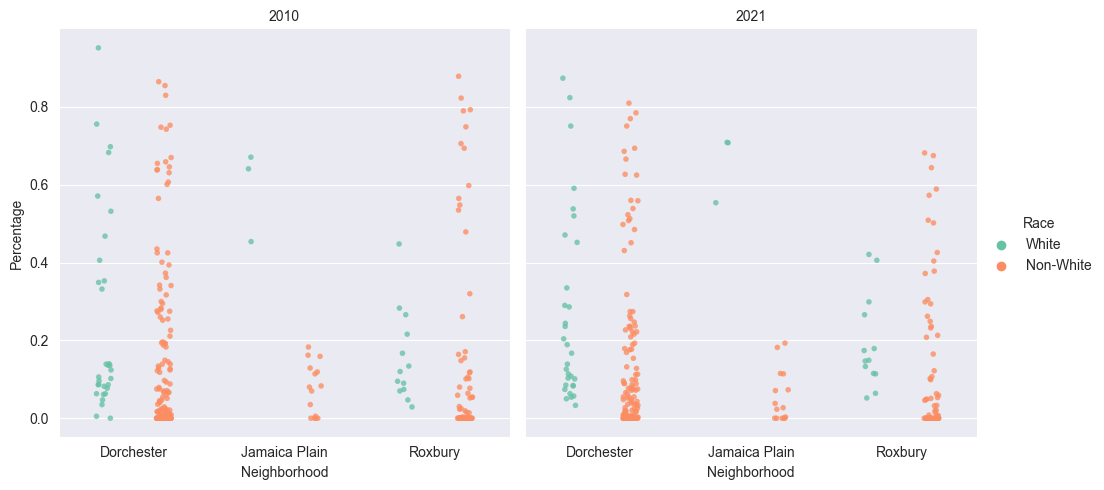

In [89]:
# Set style
custom_palette = sns.color_palette("Set2")
plt.figure(figsize=(18, 4))

# Catplot for white and non-white populations
cat_plot = sns.catplot(data=df_race_melt[((df_race_melt['race_2']== 'non_white') |(df_race_melt['race_2']== 'white'))
                                         &( (df_race_melt['year']== 2010)|(df_race_melt['year']== 2021) )],
                       x="neighborhood", y="percentage", hue="race_2", dodge=True,
                       palette = custom_palette, col='year', size=4, alpha =0.78)

# Label axes
cat_plot.set_axis_labels("Neighborhood", "Percentage")  # Modify x-axis and y-axis labels
cat_plot.set_titles(col_template="{col_name}", row_template="{row_name}")  # Show year as subplot titles

# Create legend
cat_plot._legend.set_title("Race")
new_legend_labels = {'non_white': 'Non-White', 'white': 'White'}
for handle, label in zip(cat_plot._legend.legendHandles, cat_plot._legend.get_texts()):
    label.set_text(new_legend_labels[label.get_text()])

# Show the plots
plt.show();

In this graph, each dot represents the population percentage of each race in one Census Tract in a neighborhood. For example, in 2010, Census Tract 1101.03 in Jamaica Plain has 6 dots on the left graph, only one of which will be assigned to 'white' category.  The other 5 correspond to (1) Black, (2) American Indian and Native Alaskan, (3) Asian, (4) Hawaiian, and (5) other races.

This distribution shows that Jamaica Plain has the largest disparity between white and non-white populations. On the other hand, Roxbury's Census Tracts are typically associated with much smaller white populations.

Between 2010 and 2021, the proportion of non-white residents decreases across all Census Tracts.

<Figure size 1300x600 with 0 Axes>

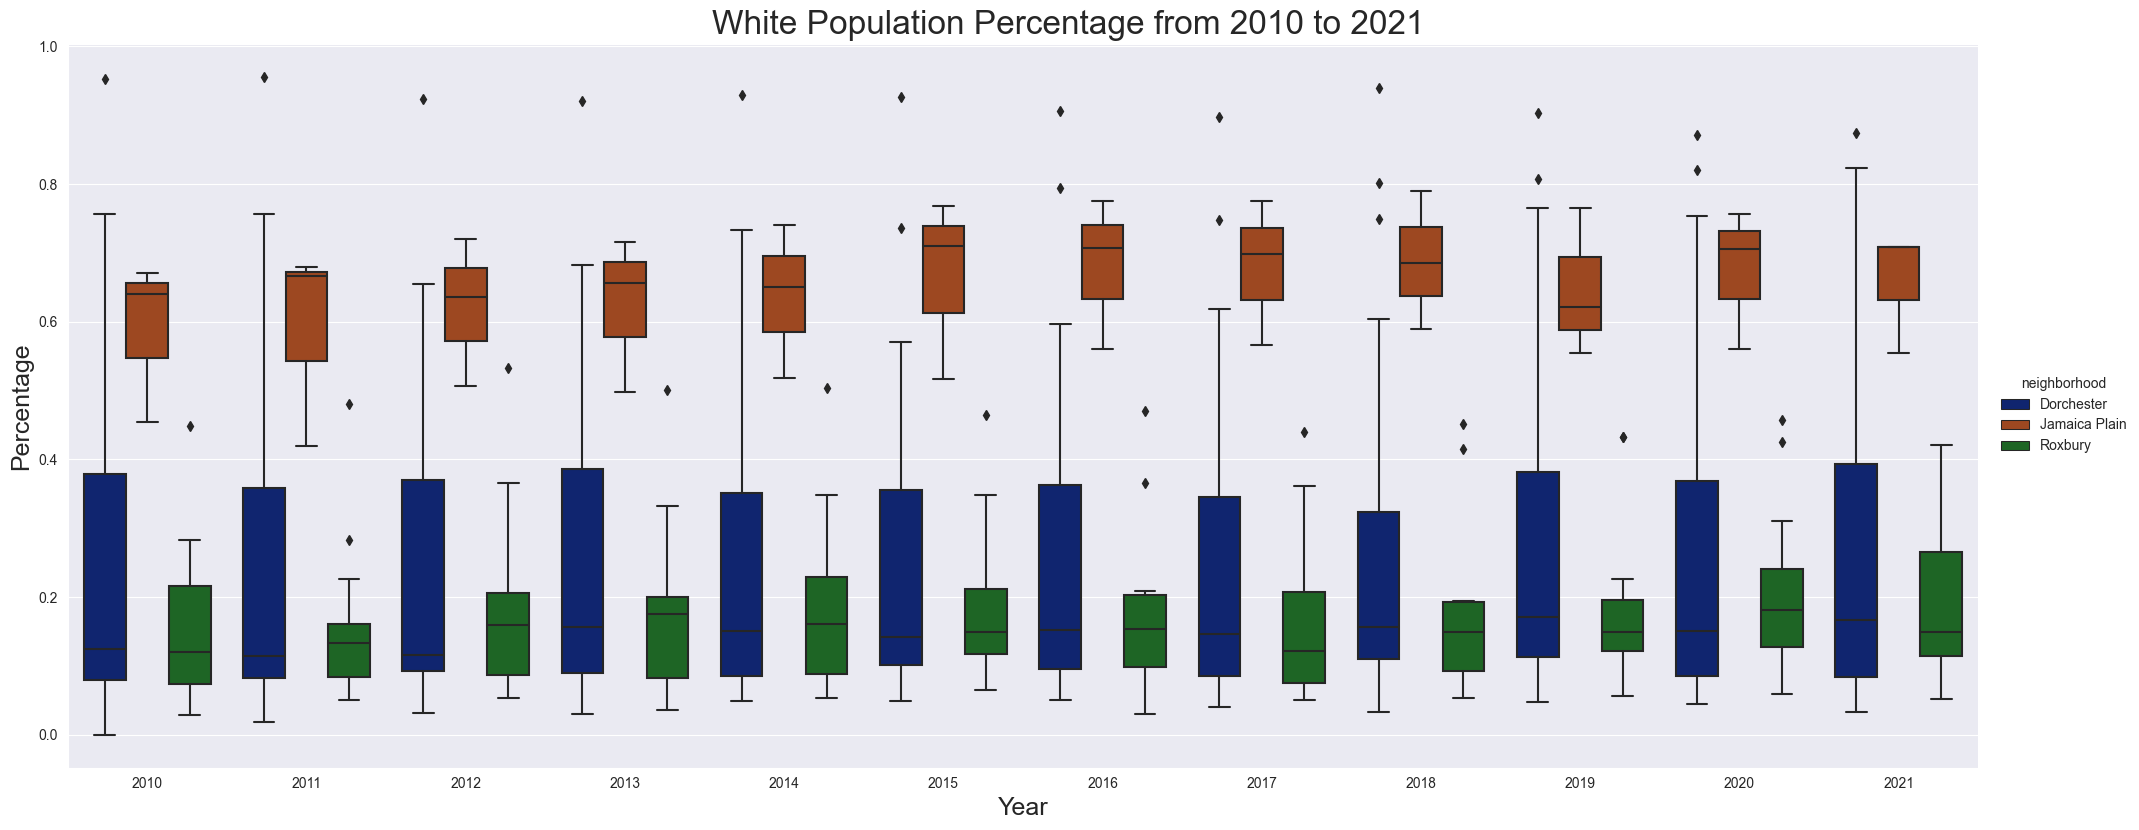

In [69]:
# Set style
plt.figure(figsize=(13, 6))

# Plot white population boxplots
sns.catplot(data=df_race_melt[(df_race_melt['race_2']=='white') & (df_race_melt['year'] >= 2010)
                              & (df_race_melt['year'] <= 2021)],
            x="year", y="percentage", hue="neighborhood",
            dodge=True, height = 8, aspect=2.5, kind='box',
            palette = custom_palette)

plt.suptitle('White Population Percentage from 2010 to 2021', y=1.02, fontsize=24)
plt.xlabel("Year", fontsize=18)
plt.ylabel("Percentage", fontsize=18);

The above graph makes clear the high median population of white residents in Census Tracts 1101.03, 1201.04, 1202.01 of Jamaica Plain, which surround the Forest Hills neighborhood, compared to all of Roxbury and Dorchester. Also, while Roxbury's Census Tracts have consistently low white populations, Dorchester displays strong right-skewness with regard to white residency. This means that while the median of white populations is low, there are areas of Dorchester with large to almost totally white populations.

### Homeownership and Neighborhood

Next, we look at rates of homeownership versus renting in each of our subject neighborhoods.

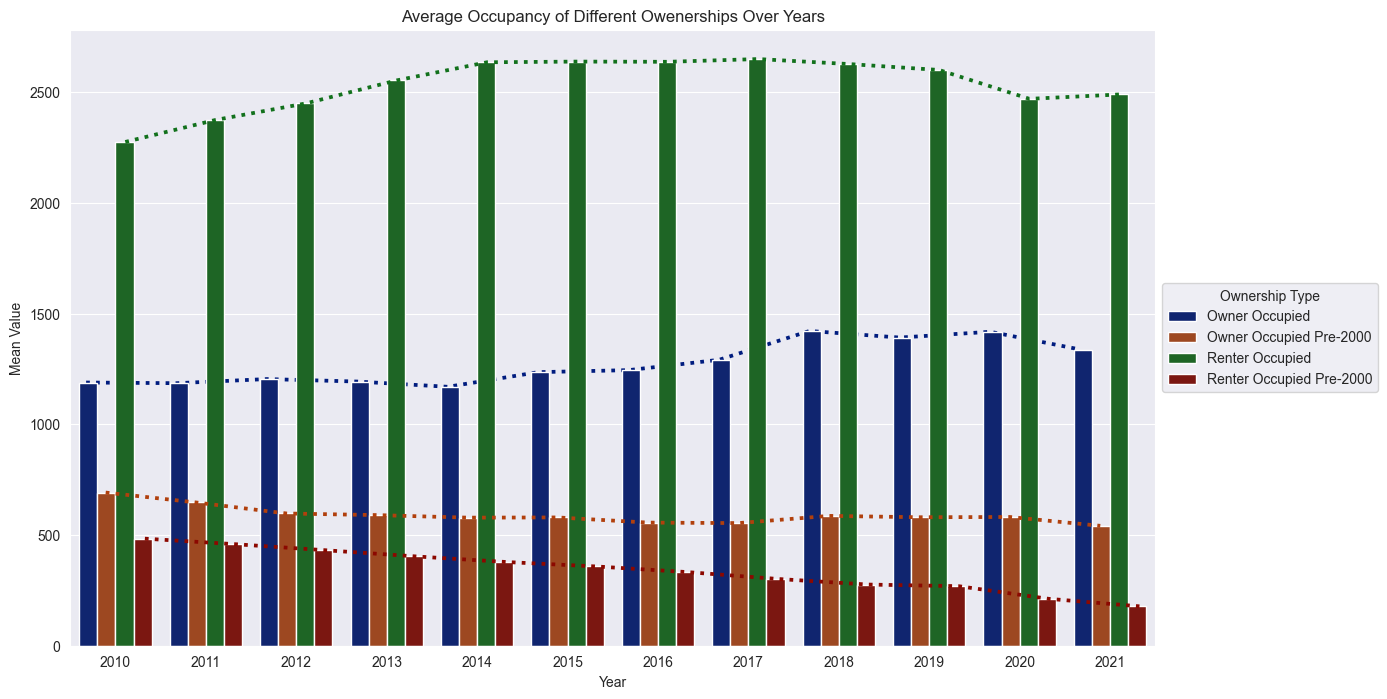

In [91]:
# Isolate homeownership data
mean_by_year = census_bike[(census_bike['year'] >= 2010) & (census_bike['year'] <= 2021)].groupby('year')[['owner_occupied', 'owner_occupied_pre-2000', 'renter_occupied', 'renter_occupied_pre-2000']].mean().reset_index()
mean_by_year_melted = mean_by_year.melt(id_vars='year', var_name='Ownership Type', value_name='Mean Value')

# Set style
plt.figure(figsize=(14, 8))
custom_palette =  sns.set_palette('dark')

# Create pointplot of mean value
sns.pointplot(data=mean_by_year_melted, x='year', y='Mean Value',
              hue='Ownership Type', palette=custom_palette,
              linestyles=':', dodge =0.65, markers='none' )

# Overlay barplot of mean value
bar_plot = sns.barplot(data=mean_by_year_melted, x='year', y='Mean Value',
                       hue='Ownership Type', palette=custom_palette)

# Create a legend for the barplot with unique categories
handles, labels = bar_plot.get_legend_handles_labels()
unique_categories = mean_by_year_melted['Ownership Type'].unique()
unique_handles = [handles[i] for i, label in enumerate(labels) if label in unique_categories][4:]
unique_labels = ['Owner Occupied', 'Owner Occupied Pre-2000', 'Renter Occupied', 'Renter Occupied Pre-2000']
bar_plot.legend(title='Ownership Type', handles=unique_handles, labels=unique_labels,
                bbox_to_anchor=(1, 0.5), loc='center left')

# Label axes
plt.title('Average Occupancy of Different Owenerships Over Years')
plt.xlabel('Year')
plt.ylabel('Mean Value')

# Show plot
plt.show();

These neighborhoods are predominantly comprised of renters. Of those, the renters who moved into their neighborhoods prior to 2000 leave at a higher rate than owners who moved in during the same era. While the measurement of residents who moved in pre-2000 cannot increase year-over-year, its rate of decreasing can inform us how quickly older populations are leaving their neighborhoods.

### Property Value and Neighborhood

Our third Census-based variable is property value, so we'll explore this next.

In [61]:
# Isolate property value data
columns = census_bike.columns[[0,1,2] + list(range(14, 17))]
df_prop_val = census_bike[list(columns)]

# Calculate ratio of rent and mortgage to property value
df_prop_val['monthly_rent_to_prop_val'] = df_prop_val['median_monthly_rent']/ df_prop_val['median_value']
df_prop_val['monthly_mort_to_prop_val'] = df_prop_val['median_monthly_mort']/ df_prop_val['median_value']

# Generate table for analysis
df_prop_val_melt = pd.melt(df_prop_val, id_vars=['year', 'tract', 'neighborhood'], var_name='value_type', value_name='value')
df_prop_val_melt

,year,tract,neighborhood,value_type,value
0,2010,1001,Dorchester,median_value,280400.0
1,2011,1001,Dorchester,median_value,276900.0
2,2012,1001,Dorchester,median_value,268000.0
3,2013,1001,Dorchester,median_value,261700.0
4,2014,1001,Dorchester,median_value,279300.0
...,...,...,...,...,...
3675,2022,923,Dorchester,monthly_mort_to_prop_val,NaN
3676,2007,924,Dorchester,monthly_mort_to_prop_val,NaN
3677,2008,924,Dorchester,monthly_mort_to_prop_val,NaN
3678,2009,924,Dorchester,monthly_mort_to_prop_val,NaN


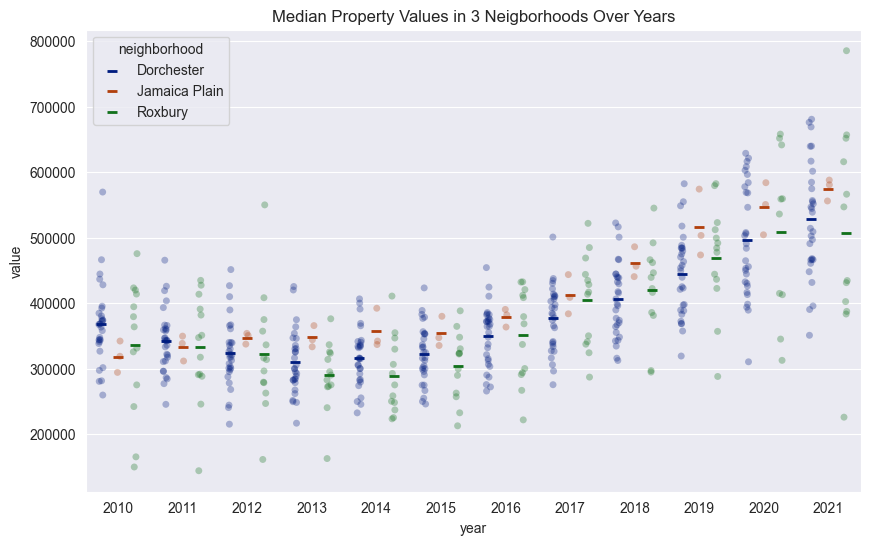

In [62]:
#Graph for Property Mean Value and Individual Observations
plt.figure(figsize=(10, 6))

# Create striplot for median
sns.stripplot(
    data=df_prop_val_melt[(df_prop_val_melt['value_type'] == 'median_value')
                          & (df_prop_val_melt['year'] >= 2010)
                          & (df_prop_val_melt['year'] <= 2021)],
    x='year', y='value',
    hue='neighborhood',
    dodge=True, alpha=.3, legend=False,
)

# Create pointplot
sns.pointplot(
    data=df_prop_val_melt[(df_prop_val_melt['value_type'] == 'median_value')
                          & (df_prop_val_melt['year'] >= 2010)
                          & (df_prop_val_melt['year'] <= 2021)],
    x='year', y='value',
    hue='neighborhood',
    dodge=.53, linestyles="none", errorbar=None,
    markers="_"
)

plt.title('Median Property Values in 3 Neigborhoods Over Years');

In 2010, we see that the median property value in all three neighborhoods was round $350,000. After that, property value in Jamaica Plain went on a steadily increasing trend, while Roxbury's and Dorchester's median property values decreased for a few years before increasing around 2015.

### Income and Neighborhood

Finally, our Census data informs us of the mean and median household income for each neighborhood.

In [63]:
# Isolate income data
columns = census_bike.columns[[0,1,2] + [17,18]] # Add all income columns
df_income = census_bike[list(columns)]

# Make new table for income
df_income_melt = pd.melt(df_income, id_vars=['year', 'tract', 'neighborhood'], var_name='income_estimate_type', value_name='dollars')
df_income_melt

,year,tract,neighborhood,income_estimate_type,dollars
0,2010,1001,Dorchester,median_income,26007.0
1,2011,1001,Dorchester,median_income,22375.0
2,2012,1001,Dorchester,median_income,27840.0
3,2013,1001,Dorchester,median_income,24886.0
4,2014,1001,Dorchester,median_income,28671.0
...,...,...,...,...,...
1467,2022,923,Dorchester,mean_income,NaN
1468,2007,924,Dorchester,mean_income,NaN
1469,2008,924,Dorchester,mean_income,NaN
1470,2009,924,Dorchester,mean_income,NaN


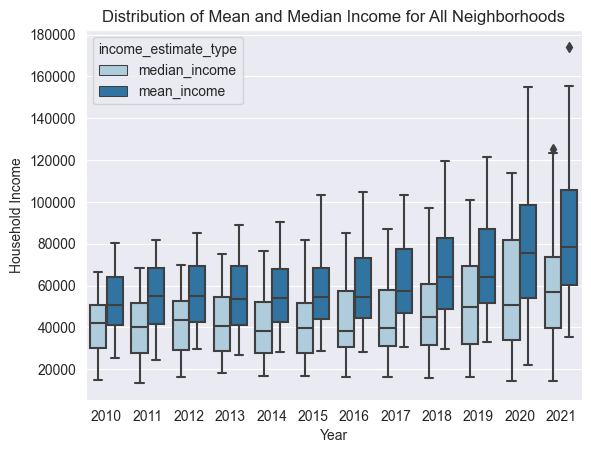

In [66]:
# Create boxplot of mean, median income
sns.boxplot(data= df_income_melt[(df_income_melt['year'] >= 2010) & (df_income_melt['year'] <= 2021) ],
            x='year', y='dollars',
            hue='income_estimate_type', palette = sns.color_palette("Paired"))
plt.title("Distribution of Mean and Median Income for All Neighborhoods")
plt.ylabel("Household Income")
plt.xlabel("Year");

The degree of separation between mean and median income can be used to assess the degree of income inequality. If a minority upper class experiences an increase in household income, mean income would increase more drastically than median income, which better describes the middle class. This is precisely the effect we observe above. Each year, the aggregate median household income for Roxbury, Dorchester, and Jamaica Plain moves further away from the median.

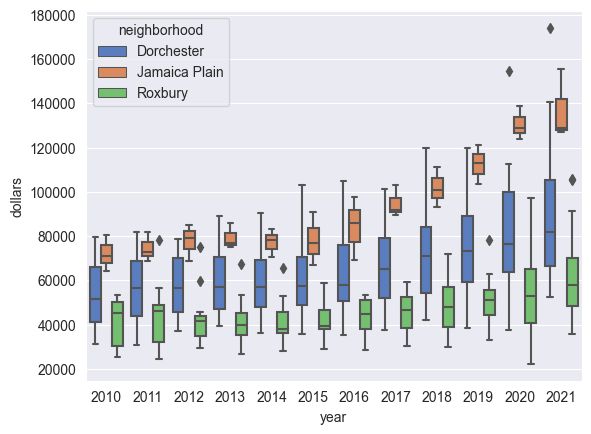

In [67]:
# Plot mean income by neighborhood
sns.boxplot(data= df_income_melt[(df_income_melt['year'] >= 2010)
                                 & (df_income_melt['year'] <= 2021)
                                 & (df_income_melt['income_estimate_type'] == 'mean_income')],
            x='year', y='dollars',hue='neighborhood', palette = sns.color_palette("muted"));

When we separate the neighborhoods, it is clear to see that the predominantly white neighborhoods in Jamaica Plain's increase in mean household income accounts for the higher degree of spread between mean and median income. Year over year, Roxbury's median average income increases only slightly, and Dorchester's still less than Jamaica Plain's.  It is worthy to note here that, as with race, Dorchester has the most diverse set of average incomes.

### Bike Lane Development and Neighborhood

In [72]:
# Create buffered tracts to show (data already includes the buffer)
tracts2010_gdf = gpd.GeoDataFrame(tracts_2010, geometry='geometry')

# Function to create a shape with a minimum distance from the polygon
def create_buffer_shape(polygon, buffer_distance):
    buffered_polygon = polygon.buffer(buffer_distance)
    return buffered_polygon

# Buffer distance in feet (800 ft)
buffer_distance_feet = 800
feet_per_degree = 364000  # approximate value for latitude

# Convert buffer distance from feet to degrees
buffer_distance_degrees = buffer_distance_feet / feet_per_degree

# Create a new column in the GeoDataFrame to store the buffered shapes
tracts2010_gdf['buffered_geometry'] = tracts2010_gdf['geometry'].apply(lambda x: create_buffer_shape(x, buffer_distance_degrees))

Roxbury_tracts = tracts2010_gdf[tracts2010_gdf['NAME10'].isin(roxbury)]
Dorchester_tracts = tracts2010_gdf[tracts2010_gdf['NAME10'].isin(dorchester)]

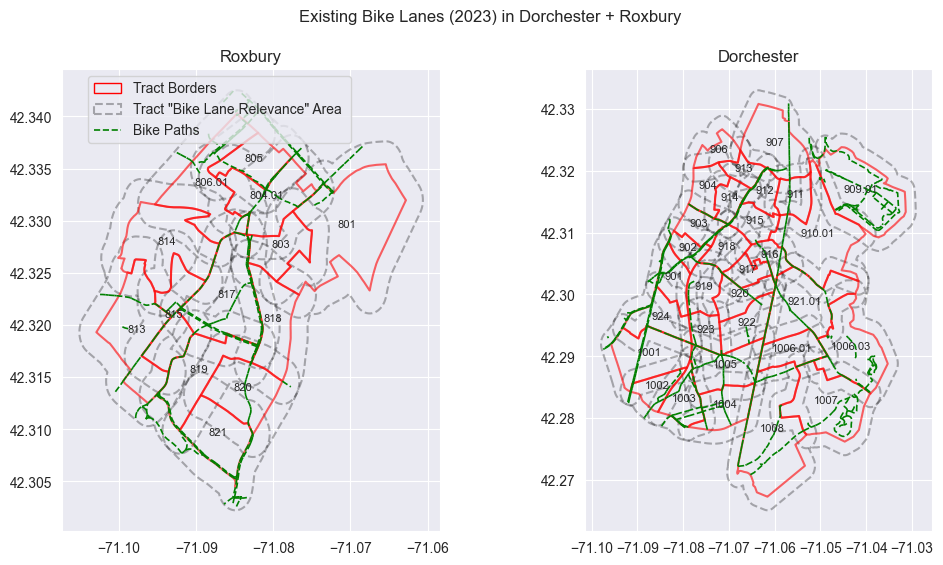

In [73]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Create a new figure and axis
fig, ax = plt.subplots(1,2, figsize = (12,6))
Roxbury_buffer = gpd.GeoDataFrame(Roxbury_tracts, geometry='buffered_geometry')
Roxbury_buffer['buffered_geometry'].plot(ax=ax[0], color='none', edgecolor='black', linestyle='dashed', linewidth=1.5, alpha=0.3, label = 'Tract "Bike Lane Relevance" Area ')
Dorchester_buffer = gpd.GeoDataFrame(Dorchester_tracts, geometry='buffered_geometry')
Dorchester_buffer['buffered_geometry'].plot(ax=ax[1], color='none', edgecolor='black', linestyle='dashed', linewidth=1.5, alpha=0.3, label = 'Tract "Bike Lane Relevance" Area ')

# create a single polygon for all buffered tracts
Roxbury_all = Roxbury_buffer.unary_union
Dorchester_all = Dorchester_buffer.unary_union

Roxbury_poly = gpd.GeoDataFrame(Roxbury_tracts, geometry='geometry')
Dorchester_poly = gpd.GeoDataFrame(Dorchester_tracts, geometry='geometry')

Roxbury_poly['geometry'].plot(ax=ax[0], color='none', edgecolor='r',  linewidth=1.5, alpha=0.6, label = "Tract Borders")
Dorchester_poly['geometry'].plot(ax=ax[1], color='none', edgecolor='r',  linewidth=1.5, alpha=0.6, label = "Tract Borders")
# Add labels to the centers of the polygons
for x, y, label in zip(Roxbury_poly.geometry.centroid.x, Roxbury_poly.geometry.centroid.y, Roxbury_poly['NAME10']):
    ax[0].text(x, y, label, fontsize=8, ha='center')
for x, y, label in zip(Dorchester_poly.geometry.centroid.x, Dorchester_poly.geometry.centroid.y, Dorchester_poly['NAME10']):
    ax[1].text(x, y, label, fontsize=8, ha='center')

# Define bike lane geodf as all bike lanes within the buffered tracts
Roxbury_bike = bike_lanes[bike_lanes.geometry.within(Roxbury_all)]
Dorchester_bike = bike_lanes[bike_lanes.geometry.within(Dorchester_all)]
Roxbury_bike_lanes = gpd.GeoDataFrame(Roxbury_bike, geometry='geometry')
Dorchester_bike_lanes = gpd.GeoDataFrame(Dorchester_bike, geometry='geometry')
Roxbury_bike_lanes['geometry'].plot(ax=ax[0], color='g', linestyle='dashed', linewidth=1.2, label = "Bike Paths")
Dorchester_bike_lanes['geometry'].plot(ax=ax[1], color='g', linestyle='dashed', linewidth=1.2, label = "Bike Paths")

ax[0].legend(handles=[Patch(facecolor='none', edgecolor='r', label='Tract Borders'),
                      Patch(facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1.5, alpha=0.3, label='Tract "Bike Lane Relevance" Area '),
                      Line2D([], [], color='g', linestyle='dashed', linewidth=1.2, label='Bike Paths')], loc='upper left', bbox_to_anchor=(0.05, 1))

ax[0].set_title('Roxbury')
ax[1].set_title('Dorchester')

plt.suptitle('Existing Bike Lanes (2023) in Dorchester + Roxbury')
plt.show()

Dorchester seems to have much more bike lanes area. Let's see if that is the case:

In [74]:
rox_dor_census_bike = census_bike[census_bike['neighborhood'].isin(['Roxbury', 'Dorchester'])]
rox_dor_census_bike.groupby('neighborhood')['total_built_all_lanes'].sum()

neighborhood
Dorchester    109698.680866
Roxbury        59472.125169
Name: total_built_all_lanes, dtype: float64

Doechester has ~X2 as many meters in new bike lanes (2010-2022). We should remember that the actual amount is lower, since many bike lanes are counted more than once, if they are inside multiple overlapping "buffered tracts". Let's see how this difference has developed over time:

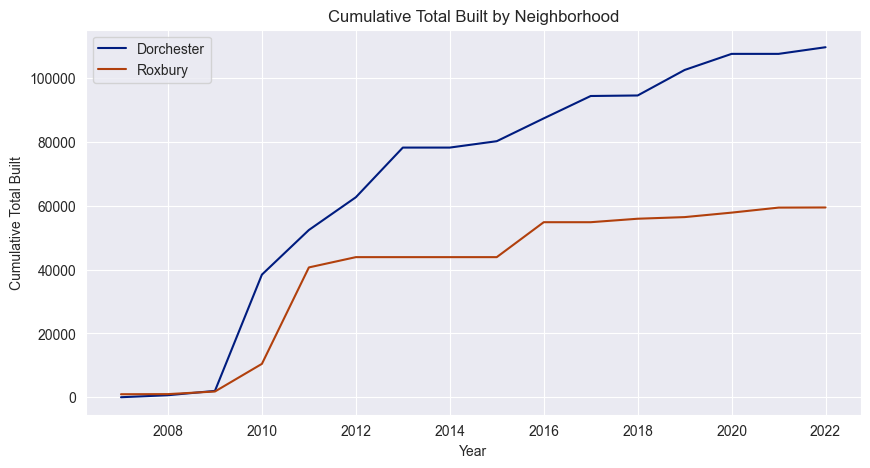

In [75]:
# plot cumulative total_built by neighborhood in census_bike across time
ax = rox_dor_census_bike.groupby(['year', 'neighborhood']).sum()['total_built_all_lanes'].unstack().cumsum().plot(figsize=(10,5))

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Total Built')
ax.set_title('Cumulative Total Built by Neighborhood')
ax.legend()
plt.show();

## Key Questions

 ### What is the _correlation_ between bike lane development and the factors leading to displacement?

Before we conduct analysis into a potential _causal_ linkage between these factors, we want to explore _correlation_. If there is no correlation whatsoever, there cannot be a causal relationship.

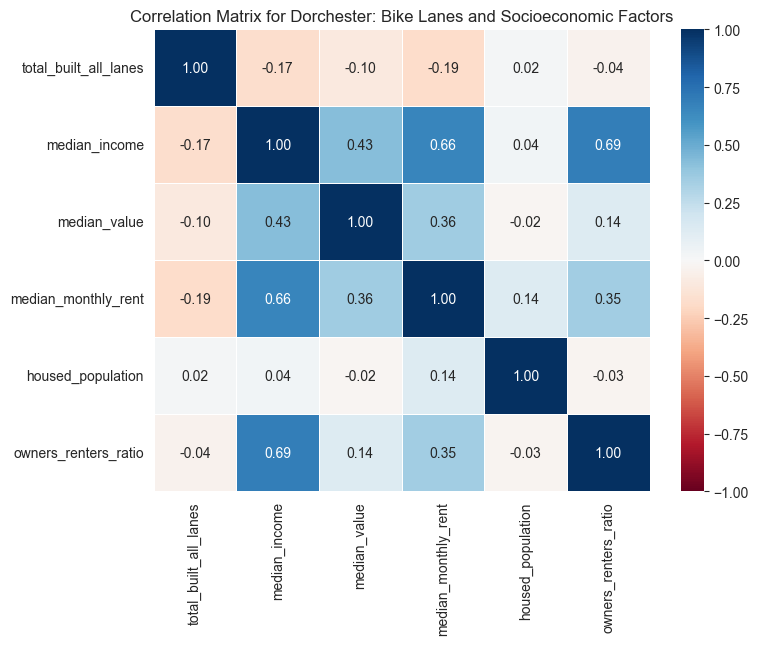

In [78]:
selected_neighborhood = 'Dorchester'
selected_columns = ['total_built_all_lanes', 'median_income', 'median_value','median_monthly_rent','housed_population','owners_renters_ratio']

# Filter the data for Dorchester and selected columns
dorchester_df = census_bike[census_bike['neighborhood'] == selected_neighborhood][selected_columns]

# Drop rows with missing values if needed
dorchester_df = dorchester_df.dropna()

# Create a correlation matrix
corr = dorchester_df.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, fmt=".2f", linewidths=.5)
plt.title(f'Correlation Matrix for {selected_neighborhood}: Bike Lanes and Socioeconomic Factors')
plt.show();

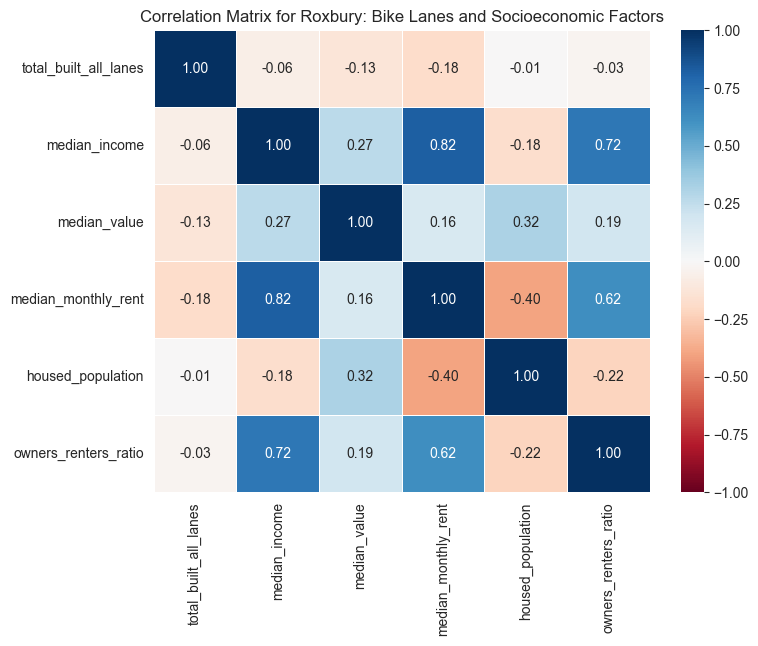

In [81]:
selected_neighborhood = 'Roxbury'
selected_columns = ['total_built_all_lanes', 'median_income', 'median_value','median_monthly_rent','housed_population','owners_renters_ratio']

# Filter the data for Roxbury and select columns
roxbury_df = census_bike[census_bike['neighborhood'] == selected_neighborhood][selected_columns]

# Drop rows with missing values if needed
roxbury_df = roxbury_df.dropna()

# Create a correlation matrix
corr = roxbury_df.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, fmt=".2f", linewidths=.5)
plt.title(f'Correlation Matrix for {selected_neighborhood}: Bike Lanes and Socioeconomic Factors')
plt.show();

From the above, we determine that an increase in bike lane development is associated with slightly lower median income, property values, rent, and the proportion of residents who own homes in both Dorchester and Roxbury. This statement does not suggest there is causation between any two factors, however.

### Do different types of bike lanes yield different effects on the factors leading to displacement?

Our client surmised that more permanent, separated bike lanes, whose construction may more significantly change the physical characteristics of a community, could relate to a heightened risk of displacement.  Here we look at the relationship between the factors leading to displacement and different _types_ of bike lanes.

The following are the abbreviations for different bike lane types:

> `BFBL`: Buffered bike lane,
> `BL`: Bike lane,
> `BLSL`: Bike lane on one side, shared lane on the opposite side,
> `BSBL`: Bus/bike lane,
> `CFBL`: Contra-flow bike street,
> `NSUP`: Shared use path, natural surface,
> `NW`: Neighborway, marked,
> `NW-U`: Neighborway, unmarked,
> `SBL`: Separated bike lane,
> `SBLBL`: Separated bike lane on one side, bike lane on the opposite side,
> `SLM`: Shared lane markings,
> `SLMTC`: Shared lane markings, Traffic calmed street,
> `SRd`: Shared road,
> `SUB`: Shared use path bridge,
> `SUC`: Shared use connector,
> `SUP`: Shared use path,
> `TC`: Traffic calmed street

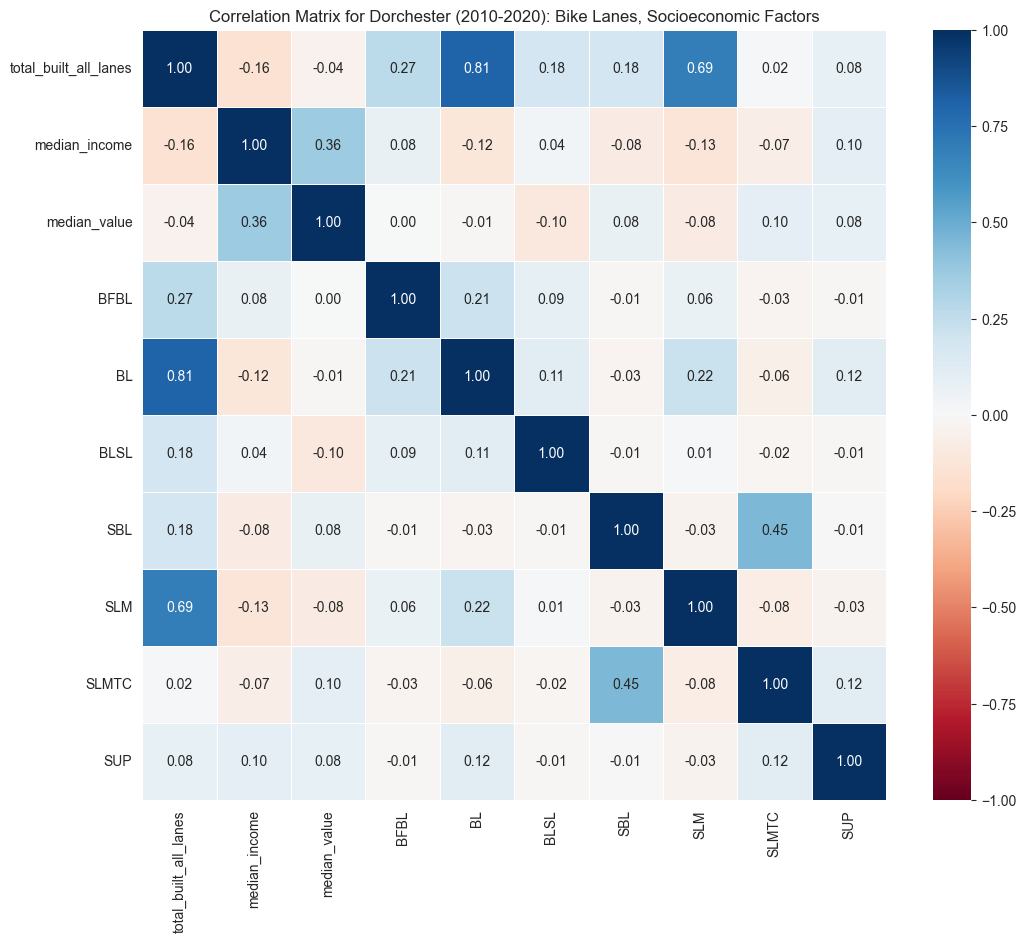

In [80]:
selected_neighborhood = 'Dorchester'
selected_columns = ['total_built_all_lanes', 'median_income', 'median_value', 'BFBL', 'BL', 'BLSL', 'SBL', 'SLM', 'SLMTC', 'SUP']

# Filter the data for Dorchester and selected years
dorchester_df = census_bike[(census_bike['neighborhood'] == selected_neighborhood) & (census_bike['year'] >= 2010) & (census_bike['year'] <= 2020)][selected_columns]

# Drop rows with missing values if needed
dorchester_df = dorchester_df.dropna()

# Create a correlation matrix
corr = dorchester_df.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, fmt=".2f", linewidths=.5)
plt.title(f'Correlation Matrix for {selected_neighborhood} (2010-2020): Bike Lanes, Socioeconomic Factors')
plt.show();

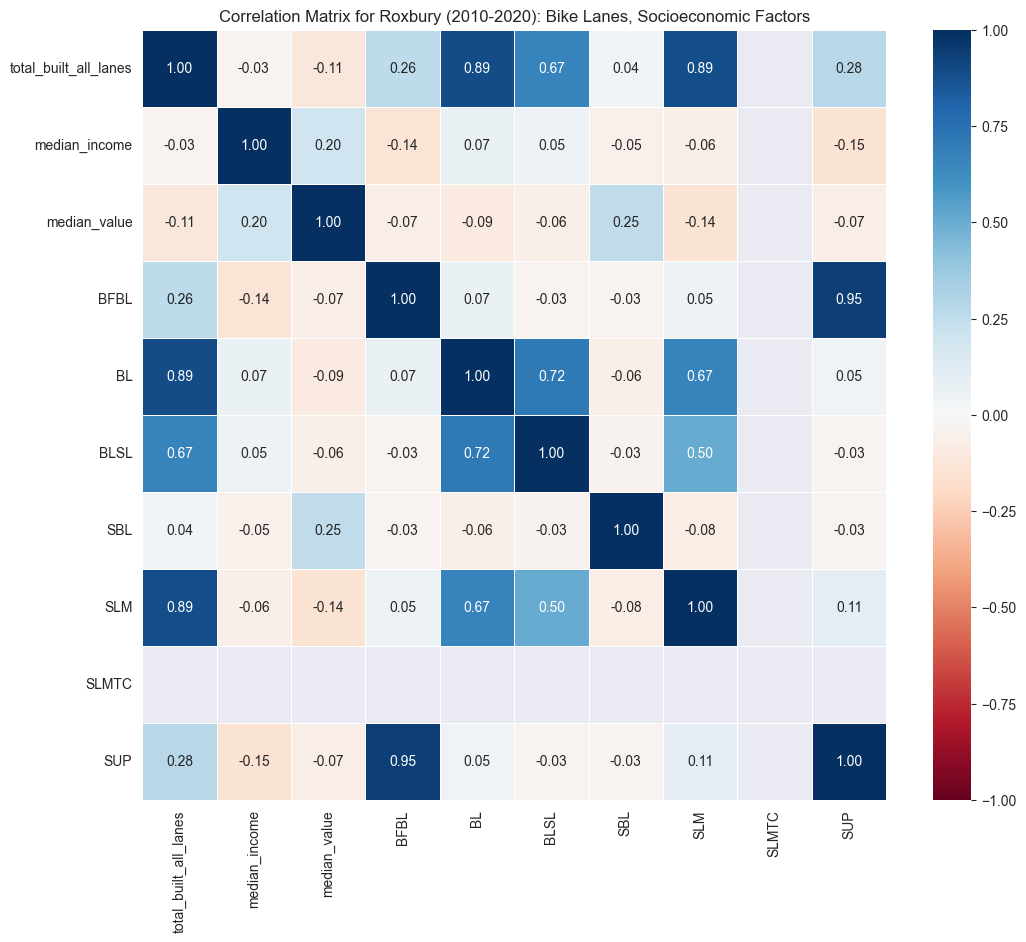

In [82]:
selected_neighborhood = 'Roxbury'
selected_columns = ['total_built_all_lanes', 'median_income', 'median_value', 'BFBL', 'BL', 'BLSL', 'SBL', 'SLM', 'SLMTC', 'SUP']

# Filter the data for Roxbury and selected years
Roxbury_df = census_bike[(census_bike['neighborhood'] == selected_neighborhood) & (census_bike['year'] >= 2010) & (census_bike['year'] <= 2020)][selected_columns]

# Drop rows with missing values if needed
Roxbury_df = Roxbury_df.dropna()

# Create a correlation matrix
corr = Roxbury_df.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, fmt=".2f", linewidths=.5)
plt.title(f'Correlation Matrix for {selected_neighborhood} (2010-2020): Bike Lanes, Socioeconomic Factors')
plt.show();

Across all our data, bike lanes (`BL`) and shared lane markings (`SLM`) were the most highly developed.  However, there is no clear correlation between any particular type of bike lane infrastructure and factors leading to displacement.

### What are the demographic and socioeconomic characteristics of neighborhoods where bike lanes are built?

In [76]:
correlation_matrix = rox_dor_census_bike[['median_income', 'total_built_all_lanes','race_white', 'median_age','percent_owners']].corr()
correlation_matrix

,median_income,total_built_all_lanes,race_white,median_age,percent_owners
median_income,1.000000,-0.143943,0.616566,0.523617,0.758639
total_built_all_lanes,-0.143943,1.000000,-0.063859,-0.113853,-0.061773
race_white,0.616566,-0.063859,1.000000,0.223517,0.414173
median_age,0.523617,-0.113853,0.223517,1.000000,0.592636
percent_owners,0.758639,-0.061773,0.414173,0.592636,1.000000


In the correlation matrix we can see that different social and economic variables are highly correlated: areas with larger white populations also have higher income, median age, and proportion of homeowners. Bike lanes tend to be built in areas that have lower income, younger populations, fewer homeowners and smaller white population. This is a simple correlational observation, but we will look closer into this relationship in the regression analysis.

Next, we look specifically within each neighborhood to see if these patterns are similar across different areas.

In [77]:
neighborhood_matrix = rox_dor_census_bike.groupby('neighborhood')[['median_income', 'total_built_all_lanes','race_white', 'median_age','percent_owners']].corr()
neighborhood_matrix

median_income  total_built_all_lanes  \
neighborhood                                                               
Dorchester   median_income               1.000000              -0.167322   
             total_built_all_lanes      -0.167322               1.000000   
             race_white                  0.699330              -0.044541   
             median_age                  0.627382              -0.121787   
             percent_owners              0.714656              -0.058356   
Roxbury      median_income               1.000000              -0.063056   
             total_built_all_lanes      -0.063056               1.000000   
             race_white                 -0.068216              -0.117292   
             median_age                  0.372543              -0.093144   
             percent_owners              0.709930              -0.023222   

                                    race_white  median_age  percent_owners  
neighborhood                                                                
Dorchester   median_income            0.699330    0.627382        0.714656  
             total_built_all_lanes   -0.044541   -0.121787       -0.058356  
             race_white               1.000000    0.435755        0.504297  
             median_age               0.435755    1.000000        0.718286  
             percent_owners           0.504297    0.718286        1.000000  
Roxbury      median_income           -0.068216    0.372543        0.709930  
             total_built_all_lanes   -0.117292   -0.093144       -0.023222  
             race_white               1.000000   -0.558410       -0.183971  
             median_age              -0.558410    1.000000        0.400473  
             percent_owners          -0.183971    0.400473        1.000000

We see similar patterns in both neighborohhods, but with some key differences: in both neighborhoods, new bike lanes are added to Census Tracts with lower income, lower median age, and lower proportions of white residents and homeowners. However, the magnitudes of these correlations is different: while in Dorchester the strongest negative relationship is between bike lanes and income, in Roxbury it is between bike lanes and white residents. This difference can be partially explained by the differences in the neighborhoods: Dorchester shows a much stronger correlation between income and race, or income and age, than Roxbury; additionally, in Roxbury the relationship between age & race is positive (higher proportion of white residents is associated with younger population) while Dorchester is the opposite. We also know from our preliminary analysis that Roxbury is more homogenously non-white and lower income than Dorchester whose distributions for these same features are broad.

## Scope Refinement and Limitations

Our project faces some challenges that are important to keep in mind.

* __Scope Constraints__: Adhering to customer specifications and time constraints, our primary analysis is confined to three specific neighborhoods in Boston—Roxbury, Dorchester, and Jamaica Plain. While these areas may serve as reasonable proxies for socioeconomic characteristics in other Boston neighborhoods, it is important to acknowledge that the statistical robustness of our analysis is limited due to the inclusion of only three neighborhoods. Furthermore, our analysis for Jamaica Plain considers only 3 Census Tracts out of 14 as opposed to Roxbury and Dorchester where we look at the neighborhood in its entirety.

* __Generalization Limitations__: Beyond the challenge of a limited geographical focus, our ability to generalize findings to broader regions is constrained. The utilization of bike lane data specific to Boston introduces variations in quality, maintenance, and other factors that may significantly differ from those in other locations. Disparities in road infrastructure, traffic conditions, and alternative transportation options across cities further emphasize the need to restrict the applicability of our analysis solely to the Boston area. Additionally, due to the structuring of our data, we cannot present particular effects as they relate to specific populations (e.g., the effect of bike lane development on income _of Black populations in Roxbury_).

* __Identification Challenges__: The core objective involves identifying a causal relationship between new bike lane development and displacement. However, both the introduction of bike lanes and changes in socioeconomic variables occur simultaneously over our data's time range, posing a challenge in establishing causality. Although we will use difference-in-difference methods to address this issue, it is important to acknowledge that complete elimination of reverse causality or other exogenous variables may not be achievable.

* __Time Horizon Limitations__: The relatively short time span of our study further complicates our ability to precisely isolate the impact of new infrastructure over time. Factors such as non-linear effects and the duration of influence introduce complexities. To mitigate these challenges, we will make assumptions about a fixed timeframe for the effects to manifest and concentrate our analysis within these defined periods.

In light of these challenges, it is imperative that we approach our analysis with a nuanced understanding of its limitations and communicate findings with a clear awareness of the contextual constraints inherent in the study design.
